In [3]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import re
import pandas as pd
import pyttsx3
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier,_tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import csv
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
#these lines load the training and testing datasets from CSV files into two pandas DataFrames, training and testing
training = pd.read_csv('Data/Training.csv')
testing= pd.read_csv('Data/Testing.csv')
cols= training.columns
cols= cols[:-1]
x = training[cols]
y = training['prognosis']
y1= y



In [6]:
#reduced_data provides the maximum values of all columns for each unique prognosis category.
reduced_data = training.groupby(training['prognosis']).max()

In [7]:
#mapping strings to numbers
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
testx    = testing[cols]
testy    = testing['prognosis']  
testy    = le.transform(testy)

In [9]:
clf1  = DecisionTreeClassifier()
clf = clf1.fit(x_train,y_train)
# print(clf.score(x_train,y_train))
# print ("cross result========")
scores = cross_val_score(clf, x_test, y_test, cv=3)
# print (scores)
print (scores.mean())

0.9729113095197496


In [10]:
#The code trains a Support Vector Classifier on the training data and then prints the accuracy of the model on the test data.

model=SVC()
model.fit(x_train,y_train)
print("for svm: ")
print(model.score(x_test,y_test))

for svm: 
1.0


In [11]:
#important feature of dataset
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = cols

In [12]:
# severityDictionary: To store severity levels.
# description_list: To store descriptions or details.
# precautionDictionary: To store precautionary measures or actions.

severityDictionary=dict()
description_list = dict()
precautionDictionary=dict()

In [14]:
# symptoms_dict: Maps symptoms to their indices.
# calc_condition(exp, days): Calculates the total severity of symptoms in exp, adjusts it based on days, and prints a recommendation based on the severity score.


symptoms_dict = {}

for index, symptom in enumerate(x):
       symptoms_dict[symptom] = index
def calc_condition(exp,days):
    sum=0
    for item in exp:
         sum=sum+severityDictionary[item]
    if((sum*days)/(len(exp)+1)>13):
        print("You should take the consultation from doctor. ")
    else:
        print("It might not be that bad but you should take precautions.")


In [15]:
# getDescription(): Reads symptom descriptions from a CSV file and updates the global description_list dictionary with these descriptions.
def getDescription():
    global description_list
    with open('MasterData/symptom_Description.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            _description={row[0]:row[1]}
            description_list.update(_description)


In [16]:
# breakdown of the getSeverityDict function, which reads symptom severities from a CSV file and updates the global severityDictionary:
def getSeverityDict():
    global severityDictionary
    with open('MasterData/symptom_severity.csv') as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        try:
            for row in csv_reader:
                _diction={row[0]:int(row[1])}
                severityDictionary.update(_diction)
        except:
            pass

In [17]:
# getprecautionDict(): Reads precautionary measures from a CSV file and updates the global precautionDictionary with these precautions.
def getprecautionDict():
    global precautionDictionary
    with open('MasterData/symptom_precaution.csv') as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            _prec={row[0]:[row[1],row[2],row[3],row[4]]}
            precautionDictionary.update(_prec)


In [18]:
# getInfo(): Greets the user and asks for their name.
# check_pattern(dis_list, inp): Checks if the input string matches any items in dis_list using regex and returns the results.
# sec_predict(symptoms_exp): Uses a trained Decision Tree classifier to predict a condition based on the given list of symptoms.


def getInfo():
    print("-----------------------------------HealthCare ChatBot-----------------------------------")
    print("\nYour Name? \t\t\t\t",end="->")
    name=input("")
    print("Hello, ",name)

def check_pattern(dis_list,inp):
    pred_list=[]
    inp=inp.replace(' ','_')
    patt = f"{inp}"
    regexp = re.compile(patt)
    pred_list=[item for item in dis_list if regexp.search(item)]
    if(len(pred_list)>0):
        return 1,pred_list
    else:
        return 0,[]
def sec_predict(symptoms_exp):
    df = pd.read_csv('Data/Training.csv')
    X = df.iloc[:, :-1]
    y = df['prognosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
    rf_clf = DecisionTreeClassifier()
    rf_clf.fit(X_train, y_train)

    symptoms_dict = {symptom: index for index, symptom in enumerate(X)}
    input_vector = np.zeros(len(symptoms_dict))
    for item in symptoms_exp:
      input_vector[[symptoms_dict[item]]] = 1

    return rf_clf.predict([input_vector])

In [19]:
# print_disease(node): Processes a Decision Tree leaf node to return a list of predicted diseases.
# tree_to_code(tree, feature_names): Handles user interaction to predict diseases based on symptoms, traverses a Decision Tree, and provides recommendations and precautions.

def print_disease(node):
    node = node[0]
    val  = node.nonzero() 
    disease = le.inverse_transform(val[0])
    return list(map(lambda x:x.strip(),list(disease)))

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    chk_dis=",".join(feature_names).split(",")
    symptoms_present = []

    while True:

        print("\nEnter the symptom you are experiencing  \t\t",end="->")
        disease_input = input("")
        conf,cnf_dis=check_pattern(chk_dis,disease_input)
        if conf==1:
            print("searches related to input: ")
            for num,it in enumerate(cnf_dis):
                print(num,")",it)
            if num!=0:
                print(f"Select the one you meant (0 - {num}):  ", end="")
                conf_inp = int(input(""))
            else:
                conf_inp=0

            disease_input=cnf_dis[conf_inp]
            break
            # print("Did you mean: ",cnf_dis,"?(yes/no) :",end="")
            # conf_inp = input("")
            # if(conf_inp=="yes"):
            #     break
        else:
            print("Enter valid symptom.")

    while True:
        try:
            num_days=int(input("Okay. From how many days ? : "))
            break
        except:
            print("Enter valid input.")
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            if name == disease_input:
                val = 1
            else:
                val = 0
            if  val <= threshold:
                recurse(tree_.children_left[node], depth + 1)
            else:
                symptoms_present.append(name)
                recurse(tree_.children_right[node], depth + 1)
        else:
            present_disease = print_disease(tree_.value[node])
            # print( "You may have " +  present_disease )
            red_cols = reduced_data.columns 
            symptoms_given = red_cols[reduced_data.loc[present_disease].values[0].nonzero()]
            # dis_list=list(symptoms_present)
            # if len(dis_list)!=0:
            #     print("symptoms present  " + str(list(symptoms_present)))
            # print("symptoms given "  +  str(list(symptoms_given)) )
            print("Are you experiencing any ")
            symptoms_exp=[]
            for syms in list(symptoms_given):
                inp=""
                print(syms,"? : ",end='')
                while True:
                    inp=input("")
                    if(inp=="yes" or inp=="no"):
                        break
                    else:
                        print("provide proper answers i.e. (yes/no) : ",end="")
                if(inp=="yes"):
                    symptoms_exp.append(syms)

            second_prediction=sec_predict(symptoms_exp)
            # print(second_prediction)
            calc_condition(symptoms_exp,num_days)
            if(present_disease[0]==second_prediction[0]):
                print("You may have ", present_disease[0])
                print(description_list[present_disease[0]])

                # readn(f"You may have {present_disease[0]}")
                # readn(f"{description_list[present_disease[0]]}")

            else:
                print("You may have ", present_disease[0], "or ", second_prediction[0])
                print(description_list[present_disease[0]])
                print(description_list[second_prediction[0]])

            # print(description_list[present_disease[0]])
            precution_list=precautionDictionary[present_disease[0]]
            print("Take following measures : ")
            for  i,j in enumerate(precution_list):
                print(i+1,")",j)

            # confidence_level = (1.0*len(symptoms_present))/len(symptoms_given)
            # print("confidence level is " + str(confidence_level))

    recurse(0, 1)





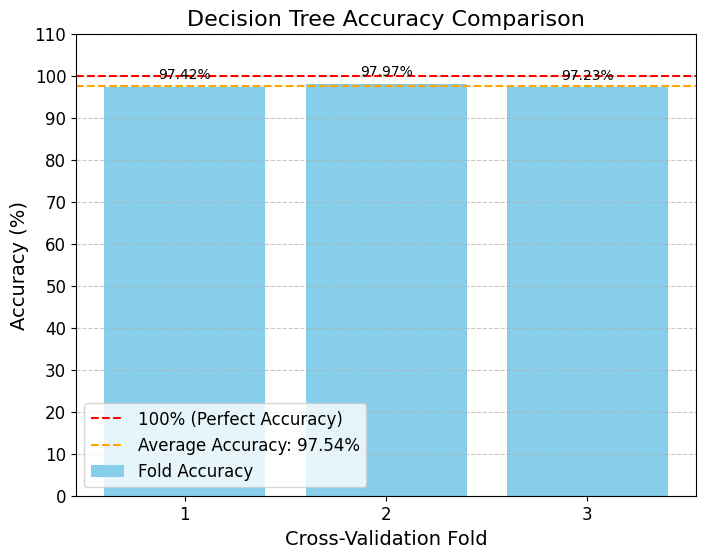

In [24]:
import matplotlib.pyplot as plt

# Cross-validation scores for the Decision Tree
cv_scores = cross_val_score(clf, x_test, y_test, cv=3)  # Already computed in your code
mean_accuracy = cv_scores.mean()

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores * 100, color='skyblue', label='Fold Accuracy')  # Convert to percentages
plt.axhline(y=100, color='red', linestyle='--', label='100% (Perfect Accuracy)')
plt.axhline(y=mean_accuracy * 100, color='orange', linestyle='--', label=f'Average Accuracy: {mean_accuracy * 100:.2f}%')

plt.ylim(0, 110)  # Show up to 110% for better visualization
plt.xlabel('Cross-Validation Fold', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Decision Tree Accuracy Comparison', fontsize=16)
plt.xticks(range(1, len(cv_scores) + 1), fontsize=12)
plt.yticks(range(0, 111, 10), fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Adding values on bars
for i, score in enumerate(cv_scores):
    plt.text(i + 1, score * 100 + 2, f"{score * 100:.2f}%", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

